## 1. Preparation 

1. ctrl-f for 'TODO' and modify

In [37]:
from __future__ import print_function
import pickle
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

def get_values(SAMPLE_SPREADSHEET_ID, SAMPLE_RANGE_NAME):
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values

## 2.0 Read Spreasheets data

* If you have error `RefreshError: ('invalid_grant: Bad Request', '{\n "error": "invalid_grant",\n "error_description": "Bad Request"\n}')`, delete `token.pickle` and try again.
* Make sure to have `credentials.json`

In [39]:
# TODO: change UID of the sheet to the correct one
SHEET_ID = '1vEhrqIefU233CMnH7zM-i8RIQiYox6oUCVDOzONZVyc'

In [77]:
# TODO: change UID of the sheet to the correct one
# Read attaquants
attaquants = get_values(SHEET_ID, 'Attaquants')
attaquants = pd.DataFrame(attaquants[2:])
attaquants = attaquants.dropna(subset=[0,36]) # Drop if no name or nan cap hits
attaquants = attaquants[attaquants[36]!='']
attaquants['pos'] = 'A'

# Read defenseurs
defenseurs = get_values(SHEET_ID, 'Defenseurs')
defenseurs = pd.DataFrame(defenseurs[2:])
defenseurs = defenseurs.dropna(subset=[0,36]) # Drop if no name or nan cap hits
defenseurs = defenseurs[defenseurs[36]!='']
defenseurs['pos'] = 'D'

# Read gardiens
gardiens = get_values(SHEET_ID, 'Gardiens')
gardiens = pd.DataFrame(gardiens[1:])
gardiens = gardiens.dropna(subset=[0,21]) # Drop if no name or nan cap hits
gardiens = gardiens[gardiens[21]!='']
gardiens['pos'] = 'G'

In [78]:
nhl = pd.concat([attaquants[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                 defenseurs[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                 gardiens[[1,2,'pos',12,21,22]].rename({1: 'name', 2: 'status', 12: 'proj', 21: 'cap_hit', 22: 'end'}, axis=1)],
                 ignore_index=True)
nhl['cap_hit'] = nhl['cap_hit'].replace(',', '', regex=True).astype(int)
nhl['proj'] = nhl['proj'].replace(to_replace='', value=0)
nhl['proj'] = nhl['proj'].astype(int)
nhl = nhl[nhl.status != 'x']

## 3.0 Knapsack
https://medium.com/@kangeugine/fantasy-football-as-a-data-scientist-part-2-knapsack-problem-6b7083955e93

In [79]:
from pulp import *

player = [str(i) for i in range(nhl.shape[0])]
point = {str(i): int(nhl['proj'].iloc[i]) for i in range(nhl.shape[0])} 
cost = {str(i): int(nhl['cap_hit'].iloc[i]) for i in range(nhl.shape[0])}
att = {str(i): 1 if nhl['pos'].iloc[i] == 'A' else 0 for i in range(nhl.shape[0])}
defe = {str(i): 1 if nhl['pos'].iloc[i] == 'D' else 0 for i in range(nhl.shape[0])}
goal = {str(i): 1 if nhl['pos'].iloc[i] == 'G' else 0 for i in range(nhl.shape[0])}
xi = {str(i): 1 for i in range(nhl.shape[0])}

In [80]:
prob = LpProblem("Fantasy Hockey", LpMaximize)
player_vars = LpVariable.dicts("Players", player, cat=LpBinary)

In [81]:
# objective function
prob += lpSum([point[i] * player_vars[i] for i in player]), "Total Cost"

In [82]:
# constraint
prob += lpSum([player_vars[i] for i in player]) == 22, "Total 20 Players"
prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 81500000, "Total Cost"
prob += lpSum([att[i] * player_vars[i] for i in player]) <= 13, "Less than 13 att"
prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 7, "Less than 7 def"
prob += lpSum([goal[i] * player_vars[i] for i in player]) <= 2, "Less than 2 goalers"

In [83]:
%%time
# solve
status = prob.solve()

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 608 ms


In [84]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

Status: Optimal


In [85]:
selection = {}
for v in prob.variables():
    index = int(v.name.split("_")[1])
    selection[index] = v.varValue
#     print(v.name, "=", v.varValue)

In [86]:
nhl['label'] = 0.0
nhl = nhl.reset_index()
for i in selection:
    nhl.loc[i, 'label'] = selection[i]

In [87]:
XI = nhl[nhl['label'] == 1.0]
TOTAL_POINTS = XI['proj'].sum()
TOTAL_COST = XI['cap_hit'].sum()
TOTAL_PLAYERS = XI.shape[0]
print("Total points: {}, cost: {}$, and with players: {}".format(TOTAL_POINTS, TOTAL_COST, TOTAL_PLAYERS))
(XI[['name','pos','proj','cap_hit', 'end']]
 .sort_values(['pos'])
 .reset_index(drop=True))

Total points: 1509, cost: 81426666$, and with players: 22


,name,pos,proj,cap_hit,end
0,Aleksander Barkov,A,85,5900000,22
1,Tim Stützle,A,52,925000,23
2,Nick Suzuki,A,60,863333,22
3,Martin Necas,A,54,863333,22
4,Mark Scheifele,A,84,6125000,24
5,Leon Draisaitl,A,116,8500000,25
6,Nathan MacKinnon,A,100,6300000,23
7,Jason Robertson,A,62,795000,22
8,Jack Hughes,A,52,925000,22
9,David Perron,A,70,4000000,22


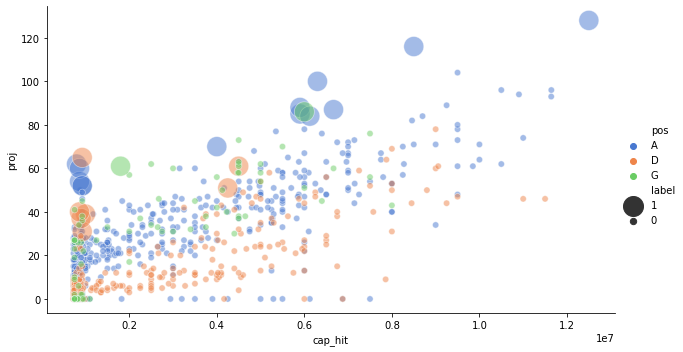

In [88]:
sns.relplot(x="cap_hit", y="proj", 
            hue="pos", size='label',
            size_order=[1,0],
            sizes=(40, 400), alpha=.5, 
            palette="muted", height=5, aspect=1.75,
            data=nhl)

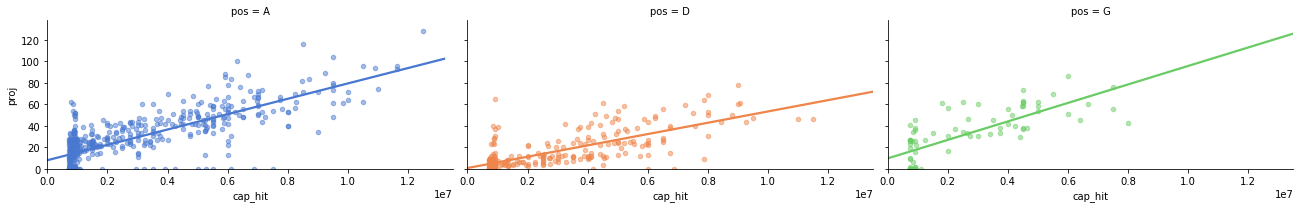

In [89]:
sns.lmplot(x="cap_hit", y="proj", col="pos", hue="pos", 
           data=nhl, aspect=2,
           col_wrap=4, ci=None, palette="muted", height=3,
#            hue_order=['DEF','GK','MID', 'STR'],
#            col_order=['DEF','GK','MID', 'STR'],
           scatter_kws={"s": 20, "alpha": 0.5})
plt.xlim(0, 1000000+max(nhl.cap_hit));
plt.ylim(0, 10+max(nhl.proj));

In [90]:
slope_inter = {}
for pos in np.unique(nhl.pos):
    pos_data = nhl[(nhl.pos == pos) & (nhl.proj >= 0)].reset_index(drop=True)
    output = linregress(pos_data['cap_hit'],pos_data['proj'])
    print("For {}, y = {:f}x + {:0.3f}".format(pos, 1000000*output.slope, output.intercept))
    slope_inter[pos] = {"slope":output.slope, "intercept":output.intercept}

For A, y = 7.139763x + 8.050
For D, y = 5.259354x + 0.816
For G, y = 8.594739x + 9.748


## 4.0 Script

In [91]:
from __future__ import print_function
import pickle
import os.path
import pandas as pd
import numpy as np
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from pulp import *


def get_values(SAMPLE_SPREADSHEET_ID, SAMPLE_RANGE_NAME):
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values


def get_selection(nhl):
    # Setup
    player = [str(i) for i in range(nhl.shape[0])]
    point = {str(i): int(nhl['proj'].iloc[i]) for i in range(nhl.shape[0])} 
    cost = {str(i): int(nhl['cap_hit'].iloc[i]) for i in range(nhl.shape[0])}
    end = {str(i): int(nhl['end'].iloc[i]) for i in range(nhl.shape[0])} 
    att = {str(i): 1 if nhl['pos'].iloc[i] == 'A' else 0 for i in range(nhl.shape[0])}
    defe = {str(i): 1 if nhl['pos'].iloc[i] == 'D' else 0 for i in range(nhl.shape[0])}
    goal = {str(i): 1 if nhl['pos'].iloc[i] == 'G' else 0 for i in range(nhl.shape[0])}
    xi = {str(i): 1 for i in range(nhl.shape[0])}
    prob = LpProblem("Fantasy Hockey", LpMaximize)
    player_vars = LpVariable.dicts("Players", player, cat=LpBinary)
    
    # Objective function
    prob += lpSum([point[i] * player_vars[i] for i in player]), "Total Cost"
    
    # Constraints
    spots_to_fill = 22 - nhl[nhl.status == 'o'].shape[0]
    prob += lpSum([player_vars[i] for i in player]) == spots_to_fill, "Total {spots_to_fill} Players"
    money_left = nhl[nhl.status == 'o']['cap_hit'].sum()
    prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 81500000 - money_left, "Total Cost"
    prob += lpSum([att[i] * player_vars[i] for i in player]) <= 13, "Less than 13 att"
    prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 7, "Less than 7 def"
    prob += lpSum([goal[i] * player_vars[i] for i in player]) <= 2, "Less than 2 goalers"
    
    # Solve
    status = prob.solve()
    
    # Selection
    selection = {}
    for v in prob.variables():
        index = int(v.name.split("_")[1])
        selection[index] = v.varValue
    nhl['label'] = 0.0
    nhl = nhl.reset_index()
    for i in selection:
        nhl.loc[i, 'label'] = selection[i]
        
    # Display
    XI = nhl[nhl['label'] == 1.0]
    TOTAL_POINTS = XI['proj'].sum()
    TOTAL_COST = XI['cap_hit'].sum()
    TOTAL_PLAYERS = XI.shape[0]
    '''
    TODO: Print current players, and players to add
    '''
    print("Total points: {}\ncost: {}\nplayers: {}".format(TOTAL_POINTS, TOTAL_COST, TOTAL_PLAYERS))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='A'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='D'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------')
    print(XI[['name','pos','proj','cap_hit', 'end']][XI['pos']=='G'].sort_values(['pos']).reset_index(drop=True))
    print('---------------------------------------------\n')

    return nhl, XI

In [94]:
def main():
    # Read attaquants
    attaquants = get_values(SHEET_ID, 'Attaquants')
    attaquants = pd.DataFrame(attaquants[2:])
    attaquants = attaquants.dropna(subset=[0,36]) # Drop if no name or nan cap hits
    attaquants = attaquants[attaquants[36]!='']
    attaquants['pos'] = 'A'

    # Read defenseurs
    defenseurs = get_values(SHEET_ID, 'Defenseurs')
    defenseurs = pd.DataFrame(defenseurs[2:])
    defenseurs = defenseurs.dropna(subset=[0,36]) # Drop if no name or nan cap hits
    defenseurs = defenseurs[defenseurs[36]!='']
    defenseurs['pos'] = 'D'

    # Read gardiens
    gardiens = get_values(SHEET_ID, 'Gardiens')
    gardiens = pd.DataFrame(gardiens[1:])
    gardiens = gardiens.dropna(subset=[0,21]) # Drop if no name or nan cap hits
    gardiens = gardiens[gardiens[21]!='']
    gardiens['pos'] = 'G'
    
    # Preprocessing
    nhl = pd.concat([attaquants[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                     defenseurs[[4,5,'pos',13,36,37]].rename({4: 'name', 5: 'status', 13: 'proj', 36: 'cap_hit', 37: 'end'}, axis=1), 
                     gardiens[[1,2,'pos',12,21,22]].rename({1: 'name', 2: 'status', 12: 'proj', 21: 'cap_hit', 22: 'end'}, axis=1)],
                     ignore_index=True)
    nhl['cap_hit'] = nhl['cap_hit'].replace(',', '', regex=True).astype(int)
    nhl['proj'] = nhl['proj'].replace(to_replace='', value=0)
    nhl['proj'] = nhl['proj'].astype(int)
    nhl = nhl[nhl.status != 'x'] # Only look at available players
    
    # Knapsack 1st tier
    print('TIER 1\n')
    nhl_selection1, X1 = get_selection(nhl)
    X1['tier'] = 1
    
    # Knapsack 2nd tier
    nhl_selection1 = nhl_selection1[nhl_selection1.label == 0.0]
    nhl_selection1 = nhl_selection1.drop(['index'], axis=1)
    print('TIER 2\n')
    nhl_selection2, X2 = get_selection(nhl_selection1)
    X2['tier'] = 2
    
    # Knapsack 3rd tier
    nhl_selection2 = nhl_selection2[nhl_selection2.label == 0.0]
    nhl_selection2 = nhl_selection2.drop(['index'], axis=1)
    print('TIER 3\n')
    nhl_selection3, X3 = get_selection(nhl_selection2)
    X3['tier'] = 3
    
    # Knapsack 4th tier
    nhl_selection3 = nhl_selection3[nhl_selection3.label == 0.0]
    nhl_selection3 = nhl_selection3.drop(['index'], axis=1)
    print('TIER 4\n')
    nhl_selection4, X4 = get_selection(nhl_selection3)
    X4['tier'] = 4
    
    # Knapsack 5th tier
    nhl_selection4 = nhl_selection4[nhl_selection4.label == 0.0]
    nhl_selection4 = nhl_selection4.drop(['index'], axis=1)
    print('TIER 5\n')
    nhl_selection5, X5 = get_selection(nhl_selection4)
    X5['tier'] = 5
    
    # Knapsack 6th tier
    nhl_selection5 = nhl_selection5[nhl_selection5.label == 0.0]
    nhl_selection5 = nhl_selection5.drop(['index'], axis=1)
    print('TIER 6\n')
    nhl_selection6, X6 = get_selection(nhl_selection5)
    X6['tier'] = 6
    
    # Knapsack 7th tier
    nhl_selection6 = nhl_selection6[nhl_selection6.label == 0.0]
    nhl_selection6 = nhl_selection6.drop(['index'], axis=1)
    print('TIER 7\n')
    nhl_selection7, X7 = get_selection(nhl_selection6)
    X7['tier'] = 7
    
    # Knapsack 8th tier
    nhl_selection7 = nhl_selection7[nhl_selection7.label == 0.0]
    nhl_selection7 = nhl_selection7.drop(['index'], axis=1)
    print('TIER 8\n')
    nhl_selection8, X8 = get_selection(nhl_selection7)
    X8['tier'] = 8
    
    # Knapsack 9th tier
    nhl_selection8 = nhl_selection8[nhl_selection8.label == 0.0]
    nhl_selection8 = nhl_selection8.drop(['index'], axis=1)
    print('TIER 9\n')
    nhl_selection9, X9 = get_selection(nhl_selection8)
    X9['tier'] = 9
    
    # Knapsack 10th tier
    nhl_selection9 = nhl_selection9[nhl_selection9.label == 0.0]
    nhl_selection9 = nhl_selection9.drop(['index'], axis=1)
    print('TIER 10\n')
    nhl_selection10, X10 = get_selection(nhl_selection9)
    X10['tier'] = 10
    
    return X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 
        
if __name__ == '__main__':
    nhl_selection1, nhl_selection2, nhl_selection3, nhl_selection4, nhl_selection5, nhl_selection6, nhl_selection7, nhl_selection8, nhl_selection9, nhl_selection10 = main()

TIER 1

Total points: 1509
cost: 81426666
players: 22
---------------------------------------------
                  name pos  proj   cap_hit end
0       Connor McDavid   A   128  12500000  26
1       Leon Draisaitl   A   116   8500000  25
2     Nathan MacKinnon   A   100   6300000  23
3   Jonathan Huberdeau   A    88   5900000  23
4       David Pastrnak   A    87   6666667  23
5    Aleksander Barkov   A    85   5900000  22
6       Mark Scheifele   A    84   6125000  24
7         David Perron   A    70   4000000  22
8      Jason Robertson   A    62    795000  22
9          Nick Suzuki   A    60    863333  22
10        Martin Necas   A    54    863333  22
11         Jack Hughes   A    52    925000  22
12         Tim Stützle   A    52    925000  23
---------------------------------------------
               name pos  proj  cap_hit end
0          Adam Fox   D    65   925000  22
1      Tyson Barrie   D    61  4500000  24
2    John Klingberg   D    51  4250000  22
3          Ty Smith   D 

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 1290
cost: 81427500
players: 22
---------------------------------------------
                name pos  proj  cap_hit end
0    Nikita Kucherov   A   104  9500000  27
1      Jake Guentzel   A    78  6000000  24
2      Brayden Point   A    78  6750000  22
3     Mika Zibanejad   A    77  5350000  22
4     Elias Lindholm   A    68  4850000  24
5     Sean Couturier   A    64  4333333  22
6         Bryan Rust   A    60  3500000  22
7        Roope Hintz   A    60  3150000  23
8   Carter Verhaeghe   A    51  1000000  22
9      Cole Caufield   A    50   880833  23
10     Trevor Zegras   A    49   925000  23
11      Joel Farabee   A    48   925000  22
12        Kirby Dach   A    46   925000  22
---------------------------------------------
               name pos  proj  cap_hit end
0        Cale Makar   D    78  9000000  27
1     Shea Theodore   D    58  5200000  25
2     Morgan Rielly   D    54  5000000  22
3    Jakob Chychrun   D    49  4600000  25
4  MacKenzie Weegar   D    42  

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 1132
cost: 81468720
players: 22
---------------------------------------------
                  name pos  proj   cap_hit end
0         Patrick Kane   A    96  10500000  23
1       Mikko Rantanen   A    89   9250000  25
2       Alex DeBrincat   A    76   6400000  23
3          Kyle Connor   A    73   7142857  26
4          Ryan Strome   A    63   4500000  22
5      Dominik Kubalik   A    54   3700000  22
6        Jack Roslovic   A    45   1838362  22
7   Yegor Sharangovich   A    43   2000000  23
8        Eeli Tolvanen   A    41   1450000  24
9    Alexis Lafrenière   A    40    925000  23
10     Kailer Yamamoto   A    39   1175000  22
11     Gabriel Vilardi   A    36    894167  22
12    Oliver Wahlstrom   A    36    894167  23
---------------------------------------------
             name pos  proj  cap_hit end
0    John Carlson   D    69  8000000  26
1  Charlie McAvoy   D    47  4900000  22
2     Devon Toews   D    43  4100000  24
3  Mattias Ekholm   D    39  3750000  22

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 1063
cost: 81482750
players: 22
---------------------------------------------
                     name pos  proj  cap_hit end
0           Sebastian Aho   A    82  8460250  24
1         Johnny Gaudreau   A    72  6750000  22
2          Nikolaj Ehlers   A    67  6000000  25
3             Tomas Hertl   A    65  5625000  22
4             Kevin Fiala   A    62  5100000  22
5   Jonathan Marchessault   A    60  5000000  24
6         Victor Olofsson   A    47  3050000  22
7            Adrian Kempe   A    41  2000000  22
8            Filip Zadina   A    35   894167  22
9             Kaapo Kakko   A    34   925000  22
10           Owen Tippett   A    33   863333  22
11           Jason Spezza   A    33   750000  22
12        Quinton Byfield   A    33   894167  24
---------------------------------------------
                name pos  proj  cap_hit end
0         Torey Krug   D    56  6500000  27
1      Samuel Girard   D    46  5000000  27
2   Zachary Werenski   D    45  5000000  22


/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 1011
cost: 81494167
players: 22
---------------------------------------------
                   name pos  proj  cap_hit end
0         Sidney Crosby   A    84  8700000  25
1     Gabriel Landeskog   A    72  7000000  28
2          Brock Boeser   A    63  5875000  22
3           Tomas Tatar   A    54  4500000  23
4       Kasperi Kapanen   A    46  3200000  22
5          Jesper Bratt   A    44  2750000  22
6     Andrew Mangiapane   A    43  2425000  22
7   Chandler Stephenson   A    43  2750000  24
8           Pavel Zacha   A    41  2250000  22
9       Jordan Greenway   A    40  2100000  22
10        Brandon Hagel   A    36  1500000  24
11         Joe Thornton   A    32   750000  22
12         Dylan Cozens   A    32   894167  23
---------------------------------------------
            name pos  proj  cap_hit end
0  Victor Hedman   D    64  7875000  25
1    Kris Letang   D    59  7250000  22
2     Jeff Petry   D    49  6250000  25
3     Seth Jones   D    47  5400000  22
4   

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 955
cost: 81440500
players: 22
---------------------------------------------
                  name pos  proj   cap_hit end
0      Mitchell Marner   A    94  10903000  25
1        Mathew Barzal   A    70   7000000  23
2     Patrice Bergeron   A    67   6875000  22
3   Oliver Bjorkstrand   A    59   5400000  26
4     Vincent Trocheck   A    54   4750000  22
5         Jordan Kyrou   A    44   2800000  23
6      Anthony Duclair   A    44   3000000  24
7           Troy Terry   A    32   1450000  23
8          Shane Pinto   A    31    925000  23
9       Mason Appleton   A    30    900000  22
10         Ryan Donato   A    29    750000  22
11       Blake Lizotte   A    28    800000  22
12     Colin Blackwell   A    28    725000  22
---------------------------------------------
            name pos  proj  cap_hit end
0     Ryan Ellis   D    47  6250000  27
1     Neal Pionk   D    46  5875000  25
2  Darnell Nurse   D    44  5600000  22
3    Mike Reilly   D    26  3000000  23
4    

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 913
cost: 81484801
players: 22
---------------------------------------------
               name pos  proj   cap_hit end
0    Artemi Panarin   A    96  11642857  26
1   Matthew Tkachuk   A    67   7000000  22
2      Sam Reinhart   A    63   6500000  24
3         Bo Horvat   A    58   5500000  23
4    Travis Konecny   A    58   5500000  25
5     Conor Garland   A    54   4950000  26
6    Rickard Rakell   A    47   3789444  22
7      Connor Brown   A    46   3600000  23
8     Robert Thomas   A    40   2800000  23
9    Denis Gurianov   A    39   2550000  22
10    Frank Vatrano   A    39   2533333  22
11     Conor Sheary   A    32   1500000  23
12      Ondrej Kase   A    31   1250000  22
---------------------------------------------
             name pos  proj  cap_hit end
0   Rasmus Dahlin   D    44  6000000  24
1  Justin Schultz   D    30  4000000  22
2      Ryan Suter   D    28  3650000  25
3     Bowen Byram   D    12   894167  23
4   Wyatt Kalynuk   D    11   925000  22
5

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 886
cost: 81499833
players: 22
---------------------------------------------
                  name pos  proj  cap_hit end
0       Max Pacioretty   A    66  7000000  23
1     Pavel Buchnevich   A    58  5800000  25
2           Zach Hyman   A    56  5500000  28
3         Dylan Strome   A    41  3000000  22
4           Pius Suter   A    41  3250000  23
5          Craig Smith   A    41  3100000  23
6   Arttu Ruotsalainen   A    28   925000  22
7      Michael Bunting   A    28   950000  23
8        Adam Gaudette   A    28   997500  22
9     Philipp Kurashev   A    28   842500  22
10          Cody Glass   A    27   863333  22
11     Derick Brassard   A    27   825000  22
12      Mathieu Joseph   A    27   737500  22
---------------------------------------------
                  name pos  proj  cap_hit end
0           Roman Josi   D    61  9059000  28
1      Dougie Hamilton   D    60  9000000  28
2         Aaron Ekblad   D    52  7500000  25
3        Alec Martinez   D    37  5

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 866
cost: 81490916
players: 22
---------------------------------------------
                 name pos  proj   cap_hit end
0     Auston Matthews   A    93  11640250  24
1          Mark Stone   A    80   9500000  27
2         Taylor Hall   A    59   6000000  25
3     Drake Batherson   A    52   4975000  27
4      Tyler Bertuzzi   A    51   4750000  23
5        Mike Hoffman   A    50   4500000  24
6        Alex Killorn   A    48   4450000  23
7   Casey Mittelstadt   A    37   2500000  24
8       Ilya Mikheyev   A    31   1645000  22
9         Ross Colton   A    28   1125000  23
10        Corey Perry   A    28   1000000  23
11        Nicolas Roy   A    26    750000  22
12      Daniel Sprong   A    25    725000  22
---------------------------------------------
              name pos  proj  cap_hit end
0    Thomas Chabot   D    53  8000000  28
1      Jake Muzzin   D    38  5625000  24
2      Ryan Pulock   D    35  5000000  22
3   Scott Mayfield   D    12  1450000  23
4  Nicola

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total points: 843
cost: 81454449
players: 22
---------------------------------------------
                 name pos  proj  cap_hit end
0      Steven Stamkos   A    71  8500000  24
1       Blake Wheeler   A    70  8250000  24
2   Andrei Svechnikov   A    67  7750000  28
3    William Nylander   A    63  6962366  24
4        Dylan Larkin   A    58  6100000  23
5    William Karlsson   A    56  5900000  27
6        Alex Iafallo   A    45  4000000  25
7        Paul Stastny   A    43  3750000  22
8         Nick Bonino   A    34  2050000  23
9      Patrick Maroon   A    26   900000  22
10       Alex Newhook   A    26   908333  23
11     Alex Formenton   A    25   747500  22
12      Morgan Geekie   A    25   750000  22
---------------------------------------------
              name pos  proj  cap_hit end
0    Jaccob Slavin   D    35  5300000  25
1  Brandon Montour   D    24  3500000  24
2    Jack Rathbone   D     9   925000  22
3      Josh Mahura   D     8   750000  23
4      Caleb Jones   D 

/home/cenoi/miniconda3/envs/pool/lib/python3.7/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
all_selections = pd.concat([nhl_selection1, nhl_selection2, nhl_selection3, nhl_selection4, nhl_selection5, nhl_selection6, nhl_selection7, nhl_selection8, nhl_selection9, nhl_selection10])
all_selections.to_csv('./all_selection.csv')